## Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from pandas.io.json import json_normalize
import geopandas as gpd
from geopy.geocoders import Nominatim
import io
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

## Loading New Delhi neighborhoods data file

#### Reading the neighborhoods file in a data frame

In [3]:
dneigh = pd.read_csv(os.getcwd() + '/delhi-neighborhood-data/delhi_dataSet.csv')

#### Print shape of the file

In [4]:
dneigh.shape

(185, 5)

In [5]:
dneigh.head()

,Unnamed: 0,Borough,Neighborhood,latitude,longitude
0,0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,2,North West Delhi,Azadpur,28.707657,77.175547
3,3,North West Delhi,Bawana,28.799660,77.032885
4,4,North West Delhi,Begum Pur,NaN,NaN


In [6]:
# drop Unnamed:0 column
dneigh.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
dneigh.head()

,Borough,Neighborhood,latitude,longitude
0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Azadpur,28.707657,77.175547
3,North West Delhi,Bawana,28.799660,77.032885
4,North West Delhi,Begum Pur,NaN,NaN


In [8]:
# dropping rows with Latitude is Null
indexNames = dneigh[ dneigh['latitude'].isnull()].index
 
# Delete these row indexes from dataFrame
dneigh.drop(indexNames , inplace=True)

# dropping rows with Longitude is Null
indexNames = dneigh[ dneigh['longitude'].isnull()].index
 
# Delete these row indexes from dataFrame
dneigh.drop(indexNames , inplace=True)

### Get New Delhi Latitude and Longitude values 

In [9]:
address = 'New Delhi, IN'

geolocator = Nominatim(user_agent="delhi_locator")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New Delhi are 28.6141793, 77.2022662.


### Create a map of New Delhi

In [10]:
# create map of New Delhi using latitude and longitude values
delhi_map = folium.Map(location=[latitude, longitude], zoom_start=10)    
delhi_map

In [11]:
# create map of New Delhi using latitude and longitude values
delhi_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dneigh['latitude'], dneigh['longitude'], dneigh['Borough'], dneigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(delhi_map)  
    
delhi_map

## Explore Borough New Delhi and South Delhi 

In [12]:
# creating a subset with only New Delhi Borough
delhi = dneigh[dneigh['Borough'] == 'New Delhi'].reset_index(drop=True)
delhi.head()

,Borough,Neighborhood,latitude,longitude
0,New Delhi,Barakhamba Road,28.629142,77.226149
1,New Delhi,Chanakyapuri,28.594678,77.188521
2,New Delhi,Connaught Place,28.631383,77.219792
3,New Delhi,Gautampuri,28.511570,77.302623
4,New Delhi,Gole Market,28.633719,77.205627


In [13]:
delhi.shape

(9, 4)

In [14]:
# creating a subset with only South Delhi Borough
southDelhi = dneigh[dneigh['Borough'] == 'South Delhi'].reset_index(drop=True)
southDelhi.head()

,Borough,Neighborhood,latitude,longitude
0,South Delhi,Alaknanda,28.529336,77.251632
1,South Delhi,Chhattarpur,28.507007,77.175417
2,South Delhi,Chittaranjan Park,28.538752,77.249249
3,South Delhi,Dayanand Colony,28.562200,77.247613
4,South Delhi,Defence Colony,28.571791,77.232010


In [15]:
# appending southDelhi dataframe to delhi dataframe
delhi = delhi.append(southDelhi, ignore_index = True)
delhi.shape

(54, 4)

In [16]:
delhi.head(7)

,Borough,Neighborhood,latitude,longitude
0,New Delhi,Barakhamba Road,28.629142,77.226149
1,New Delhi,Chanakyapuri,28.594678,77.188521
2,New Delhi,Connaught Place,28.631383,77.219792
3,New Delhi,Gautampuri,28.511570,77.302623
4,New Delhi,Gole Market,28.633719,77.205627
5,New Delhi,Golf Links,28.595970,77.231163
6,New Delhi,INA Colony,28.579472,77.212451


In [17]:
# create map of New Delhi and South Delhi using latitude and longitude values
delhi_borough = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(delhi['latitude'], delhi['longitude'], delhi['Borough'], delhi['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(delhi_borough)  
    
delhi_borough

## Using FourSquare to get Restaurants list based on price range i.e 1,2,3,4 
#### 1 being least expensive and 4 being very expensive

In [18]:
CLIENT_ID = '32R31NFZEJX05XSVG15ARLETKBKEMJG3LH4KNAD1ZBQL405Z'
CLIENT_SECRET = 'NAJI0UF1UPOCQUDYC3MF0SBIAY3ELS4APRLRMBBMNEUONAV4'
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 32R31NFZEJX05XSVG15ARLETKBKEMJG3LH4KNAD1ZBQL405Z
CLIENT_SECRET:NAJI0UF1UPOCQUDYC3MF0SBIAY3ELS4APRLRMBBMNEUONAV4


In [19]:
# get neighborhood's coordinates
neighborhood_latitude = delhi.loc[0, 'latitude'] 
neighborhood_longitude = delhi.loc[0, 'longitude'] 

neighborhood_name = delhi.loc[0, 'Neighborhood'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Barakhamba Road are 28.6291417, 77.22614890000001.


In [20]:
# Fetch venues using explore endpoint
LIMIT = 50
radius = 100
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=32R31NFZEJX05XSVG15ARLETKBKEMJG3LH4KNAD1ZBQL405Z&client_secret=NAJI0UF1UPOCQUDYC3MF0SBIAY3ELS4APRLRMBBMNEUONAV4&v=20180605&ll=28.6291417,77.22614890000001&radius=100&limit=50'

In [21]:
# display the results of the above call in json format
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eaa2cf9618f43001cb5df84'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'N.D. Charge 1',
  'headerFullLocation': 'N.D. Charge 1, Delhi',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 28.6300417009, 'lng': 77.227172347854},
   'sw': {'lat': 28.628241699100002, 'lng': 77.22512545214603}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc8f2c5762beee1a7bb3d38',
       'name': 'Hans Hotel New Delhi',
       'location': {'address': '15 Barakhamba Road',
        'lat': 28.628377699752495,
        'lng': 77.22585594873043,
        'labeledLatLngs': [{'labe

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
# printing json data into a dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng,id
0,Hans Hotel New Delhi,Hotel,28.628378,77.225856,4bc8f2c5762beee1a7bb3d38
1,India Coffee House,Café,28.629263,77.226631,4ecccbc9e5fa85e5eca863e6


In [22]:
# get venues for all locations in New Delhi and South Delhi
def getVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    allvenues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    allvenues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue ID',
                  'Venue Category']
    
    return(allvenues)

In [23]:
delhiVenues = getVenues(delhi['Neighborhood'], delhi['latitude'], delhi['longitude'])

Barakhamba Road
Chanakyapuri
Connaught Place
Gautampuri
Gole Market
Golf Links
INA Colony
Khan Market
Pragati Maidan
Alaknanda
Chhattarpur
Chittaranjan Park
Dayanand Colony
Defence Colony
East of Kailash
Friends Colony
Govindpuri
Greater Kailash
Green Park
Gulmohar Park
Hauz Khas
Hauz Khas Village
Jaitpur
Jangpura
Jasola
Jor Bagh
Kailash Colony
Kalkaji
Khanpur
Khirki Village
Lajpat Nagar
Lodi Colony
Maharani Bagh
Malviya Nagar
Mehrauli
Neeti Bagh
Nehru Place
Netaji Nagar
New Friends Colony
Nizamuddin West
Okhla
Safdarjung Enclave
Sainik Farm
Saket
Sangam Vihar
Sarita Vihar
Sarojini Nagar
Sarvodaya Enclave
Shahpur Jat
Siri Fort
South Extension
Sriniwaspuri
Tughlaqabad
Badarpur


In [24]:
delhiVenues.shape

(539, 8)

In [25]:
delhiVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Barakhamba Road,28.629142,77.226149,The Lalit Hotel,28.631110,77.227450,4bb46ce087aa95219724add1,Hotel
1,Barakhamba Road,28.629142,77.226149,Tamasha,28.629663,77.221835,56c6e01ccd10173283f8534e,Gastropub
2,Barakhamba Road,28.629142,77.226149,Ugrasen ki Baoli (Agrasen ki Baoli),28.625820,77.224955,4e070cdad22d658532a39289,Historic Site
3,Barakhamba Road,28.629142,77.226149,Chew,28.632002,77.222706,52e226ef498e7591ee3213db,Asian Restaurant
4,Barakhamba Road,28.629142,77.226149,Cha Bar | चा बार,28.630920,77.222194,51690773e4b09433491d990e,Tea Room


In [26]:
# get all unique category values 
delhiVenues['Venue Category'].unique()

array(['Hotel', 'Gastropub', 'Historic Site', 'Asian Restaurant',
       'Tea Room', 'Salon / Barbershop', 'Hotel Bar',
       'Performing Arts Venue', 'Trail', 'Plaza', 'Indian Restaurant',
       'Clothing Store', 'Bistro', 'Molecular Gastronomy Restaurant',
       'Coffee Shop', 'Bakery', 'Food Truck', 'Café', 'Lounge',
       'North Indian Restaurant', 'South Indian Restaurant',
       'Ice Cream Shop', 'Deli / Bodega', 'BBQ Joint',
       'Portuguese Restaurant', 'Chinese Restaurant', 'Donut Shop',
       'Beer Garden', 'Bar', 'Pub', 'Italian Restaurant',
       'Food & Drink Shop', 'Flea Market', 'Fast Food Restaurant',
       'Snack Place', 'Japanese Restaurant', 'Fabric Shop', 'Theater',
       'Golf Course', 'Spa', 'Antique Shop', 'Park', 'Art Gallery',
       'Airport', 'Light Rail Station', 'Market', 'Irani Cafe',
       'French Restaurant', 'Bookstore', 'Furniture / Home Store',
       'Mediterranean Restaurant', 'Boutique', 'Restaurant',
       'Mexican Restaurant', 'Food'

In [27]:
# delete rows with categories not of our interest
value = ['Hotel','Bar','Historic Site','Miscellaneous Shop','Clothing Store','Sculpture Garden','Arcade','Salon / Barbershop',
        'Airport','Castle','ATM','Train Station','Light Rail Station','Hotel Bar','Performing Arts Venue','Trail',
        'Bus Station','Market','Plaza','Golf Course','Neighborhood','Motorcycle Shop','Event Space','Playground',
        'Public Art','Hospital','Clinic','Business Service',"Women's Store",'Stadium','Bridal Shop',
        'Frozen Yogurt Shop', 'Electronics Store', 'Candy Store',
        'History Museum', 'IT Services','Toy / Game Store', 'Cosmetics Shop', 'Diner', 'Food Court',
        'Soccer Stadium', 'Soccer Field', 'Gym / Fitness Center','Shopping Mall','Athletics & Sports', 'Music Venue',
        'Gym','Rock Club','Hot Dog Joint', 'Department Store', 'Bed & Breakfast','Nightclub',
        'Bowling Alley','Indie Movie Theater','Metro Station','Boutique','Bookstore', 'Furniture / Home Store',
        'Theater', 'Antique Shop','Park','Art Gallery', 'Fabric Shop','Flea Market','Lounge',]
def dropColumns(value,df):
    for i in value:
        indexNames = df[ delhiVenues['Venue Category'] == i].index
        df.drop(indexNames , inplace=True)
    return df

In [28]:
dropColumns(value,delhiVenues)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
1,Barakhamba Road,28.629142,77.226149,Tamasha,28.629663,77.221835,56c6e01ccd10173283f8534e,Gastropub
3,Barakhamba Road,28.629142,77.226149,Chew,28.632002,77.222706,52e226ef498e7591ee3213db,Asian Restaurant
4,Barakhamba Road,28.629142,77.226149,Cha Bar | चा बार,28.630920,77.222194,51690773e4b09433491d990e,Tea Room
10,Connaught Place,28.631383,77.219792,Rajdhani Thali,28.629999,77.220401,4cbb2592dd41a35df95eeca0,Indian Restaurant
12,Connaught Place,28.631383,77.219792,Johnny Rockets,28.630457,77.219594,571a5505498ef32d7975392f,Bistro
...,...,...,...,...,...,...,...,...
528,South Extension,28.568566,77.220568,Bengali Sweets,28.569538,77.220940,4b9646a6f964a5208cc334e3,Indian Restaurant
529,South Extension,28.568566,77.220568,McDonald's,28.568451,77.219503,4bed2b00bac3c9b677e0fde9,Fast Food Restaurant
530,South Extension,28.568566,77.220568,Pind Balluchi,28.569525,77.224301,4c9a40ba78fc236a28f53397,Food Truck
532,Sriniwaspuri,28.565220,77.254704,AIESEC Delhi IIT Office,28.562111,77.251912,4dbfe4d91e72dd48b1fb6de3,Wine Bar


In [29]:
delhiVenues.shape

(351, 8)

In [30]:
delhiVenues.reset_index()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,1,Barakhamba Road,28.629142,77.226149,Tamasha,28.629663,77.221835,56c6e01ccd10173283f8534e,Gastropub
1,3,Barakhamba Road,28.629142,77.226149,Chew,28.632002,77.222706,52e226ef498e7591ee3213db,Asian Restaurant
2,4,Barakhamba Road,28.629142,77.226149,Cha Bar | चा बार,28.630920,77.222194,51690773e4b09433491d990e,Tea Room
3,10,Connaught Place,28.631383,77.219792,Rajdhani Thali,28.629999,77.220401,4cbb2592dd41a35df95eeca0,Indian Restaurant
4,12,Connaught Place,28.631383,77.219792,Johnny Rockets,28.630457,77.219594,571a5505498ef32d7975392f,Bistro
...,...,...,...,...,...,...,...,...,...
346,528,South Extension,28.568566,77.220568,Bengali Sweets,28.569538,77.220940,4b9646a6f964a5208cc334e3,Indian Restaurant
347,529,South Extension,28.568566,77.220568,McDonald's,28.568451,77.219503,4bed2b00bac3c9b677e0fde9,Fast Food Restaurant
348,530,South Extension,28.568566,77.220568,Pind Balluchi,28.569525,77.224301,4c9a40ba78fc236a28f53397,Food Truck
349,532,Sriniwaspuri,28.565220,77.254704,AIESEC Delhi IIT Office,28.562111,77.251912,4dbfe4d91e72dd48b1fb6de3,Wine Bar


### Fetch likes for venues in Borough New Delhi and South Delhi

In [31]:
# dictionary storing likes count based on the venue ID
likes = {'Venue ID': [], 'Likes Count':[]}

In [32]:
# function reads the json output and fetches relevant values i.e. likes count and append it to dictionary
def getLikes(data):
    results = requests.get(url).json()["response"]
    count = results['likes']['count']
    likes['Likes Count'].append(count)
    return likes

In [33]:
# make GET request to likes endpoint
for venue_id in delhiVenues['Venue ID']:
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION
        )
        getLikes(likes)
        likes['Venue ID'].append(venue_id)

In [34]:
likesDf = pd.DataFrame()
likesDf['Venue ID'] = likes['Venue ID']
likesDf['Likes Count'] = likes['Likes Count']

In [35]:
likesDf.shape

(351, 2)

In [36]:
# join likesDf to delhiVenues on Venue ID
newDf = delhiVenues.join(likesDf.set_index('Venue ID'), on='Venue ID')

In [37]:
newDf.dropna(inplace = True)

In [38]:
newDf.shape

(383, 9)

In [39]:
newDf['Likes Count'].unique()

array([ 20,  26,  74,  25,   8,  28, 374, 174,   6,  14,  48,  99,  22,
        29,  30,  53,  89,   7,  56, 106,  31,  71, 178,  38,  10,  97,
         3,  12,  15,   5,   0,   2,   1, 251,  39,  27, 121,   9,  23,
        55,  37,  32,  16,  11,   4,  34,  18,  13,  42,  92,  72,  33,
        24, 170, 197,  46, 109, 285,  44, 124,  19, 107,  35,  52,  61],
      dtype=int64)

In [40]:
newDf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Likes Count
1,Barakhamba Road,28.629142,77.226149,Tamasha,28.629663,77.221835,56c6e01ccd10173283f8534e,Gastropub,20
1,Barakhamba Road,28.629142,77.226149,Tamasha,28.629663,77.221835,56c6e01ccd10173283f8534e,Gastropub,20
3,Barakhamba Road,28.629142,77.226149,Chew,28.632002,77.222706,52e226ef498e7591ee3213db,Asian Restaurant,26
3,Barakhamba Road,28.629142,77.226149,Chew,28.632002,77.222706,52e226ef498e7591ee3213db,Asian Restaurant,26
4,Barakhamba Road,28.629142,77.226149,Cha Bar | चा बार,28.630920,77.222194,51690773e4b09433491d990e,Tea Room,74


In [41]:
# group on Neighborhood
delhi_grouped = newDf.groupby('Neighborhood').mean().reset_index()
delhi_grouped.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Likes Count
0,Alaknanda,28.529336,77.251632,28.528475,77.249834,2.181818
1,Barakhamba Road,28.629142,77.226149,28.630862,77.222245,40.000000
2,Chhattarpur,28.507007,77.175417,28.506753,77.175013,0.500000
3,Chittaranjan Park,28.538752,77.249249,28.540817,77.249825,1.500000
4,Connaught Place,28.631383,77.219792,28.631872,77.219801,49.880952


## Clustering

In [42]:
# drop columns other than likes column
clusterDf = delhi_grouped.drop(columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude'
                                         ,'Venue Longitude'], axis = 1)

In [43]:
clusterDf.shape

(41, 1)

In [44]:
# Use elbow technique to get apt number of clusters
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(clusterDf)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 

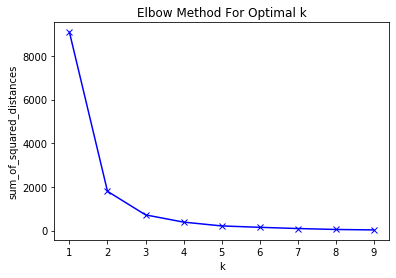

In [45]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

#### From the above graph, k = 3 is ideal number of cluster

In [46]:
# fit on the dataset with 3 clusters
kmeans = KMeans(n_clusters=3, random_state = 0).fit(clusterDf)

In [47]:
kmeans.labels_[0:10]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [48]:
# append cluster column to delhi_grouped 
delhi_grouped.insert(0,'Cluster',kmeans.labels_)

In [49]:
delhi_grouped.head()

,Cluster,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Likes Count
0,0,Alaknanda,28.529336,77.251632,28.528475,77.249834,2.181818
1,1,Barakhamba Road,28.629142,77.226149,28.630862,77.222245,40.000000
2,0,Chhattarpur,28.507007,77.175417,28.506753,77.175013,0.500000
3,0,Chittaranjan Park,28.538752,77.249249,28.540817,77.249825,1.500000
4,1,Connaught Place,28.631383,77.219792,28.631872,77.219801,49.880952


In [50]:
kclusters = 3
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_grouped['Neighborhood Latitude'], delhi_grouped['Neighborhood Longitude'], delhi_grouped['Neighborhood'], delhi_grouped['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
# Cluster 1
delhi_grouped.loc[delhi_grouped['Cluster'] == 0, delhi_grouped.columns[[1] + list(range(5, delhi_grouped.shape[1]))]]

,Neighborhood,Venue Longitude,Likes Count
0,Alaknanda,77.249834,2.181818
2,Chhattarpur,77.175013,0.500000
3,Chittaranjan Park,77.249825,1.500000
5,Dayanand Colony,77.245805,5.000000
6,Defence Colony,77.230621,9.812500
7,East of Kailash,77.244994,2.375000
8,Friends Colony,77.261516,0.000000
9,Gole Market,77.207874,3.600000
10,Golf Links,77.232194,1.000000
11,Greater Kailash,77.232018,3.818182


In [52]:
# Cluster 2
delhi_grouped.loc[delhi_grouped['Cluster'] == 1, delhi_grouped.columns[[1] + list(range(5, delhi_grouped.shape[1]))]]

,Neighborhood,Venue Longitude,Likes Count
1,Barakhamba Road,77.222245,40.000000
4,Connaught Place,77.219801,49.880952
17,Kailash Colony,77.242078,40.400000
20,Khirki Village,77.218093,41.621622
33,Saket,77.216635,63.333333


In [53]:
# Cluster 3
delhi_grouped.loc[delhi_grouped['Cluster'] == 2, delhi_grouped.columns[[1] + list(range(5, delhi_grouped.shape[1]))]]

,Neighborhood,Venue Longitude,Likes Count
13,Hauz Khas,77.208543,16.000000
14,Hauz Khas Village,77.194612,13.842105
18,Khan Market,77.227050,24.264706
26,Neeti Bagh,77.218434,16.666667
27,Nehru Place,77.251616,20.058824
37,Shahpur Jat,77.214227,20.500000


In [60]:
# merge to get Borough column with clusters
withBorough = delhi_grouped.merge(delhi, on = 'Neighborhood', how = 'left')

In [63]:
withBorough.head()

,Cluster,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Likes Count,Borough,latitude,longitude
0,0,Alaknanda,28.529336,77.251632,28.528475,77.249834,2.181818,South Delhi,28.529336,77.251632
1,1,Barakhamba Road,28.629142,77.226149,28.630862,77.222245,40.000000,New Delhi,28.629142,77.226149
2,0,Chhattarpur,28.507007,77.175417,28.506753,77.175013,0.500000,South Delhi,28.507007,77.175417
3,0,Chittaranjan Park,28.538752,77.249249,28.540817,77.249825,1.500000,South Delhi,28.538752,77.249249
4,1,Connaught Place,28.631383,77.219792,28.631872,77.219801,49.880952,New Delhi,28.631383,77.219792
